In [1]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img

%load_ext autoreload
%autoreload 2

# 0. Define the Loss function

As we encode the labels as well, cross entropy function should take the one-hot vector with softed value as an input.
However, cross entorpy function supported by pytorch only takes one dimensional label (e.g [1,0,9,...] where entries presents class labels).
Hence, now I define my cross entropy function here.

In [106]:
def my_cross_entropy(input, target, size_average=True):
    """ Cross entropy that accepts soft targets
    Args:
         pred: predictions for neural network
         targets: targets, can be soft
         size_average: if false, sum is returned instead of mean

    Examples::

        input = torch.FloatTensor([[1.1, 2.8, 1.3], [1.1, 2.1, 4.8]])
        input = torch.autograd.Variable(out, requires_grad=True)

        target = torch.FloatTensor([[0.05, 0.9, 0.05], [0.05, 0.05, 0.9]])
        target = torch.autograd.Variable(y1)
        loss = cross_entropy(input, target)
        loss.backward()
    """
    logsoftmax = nn.LogSoftmax(dim=1)
    if size_average:
        return torch.mean(torch.sum(-target * logsoftmax(input) , dim=1))
    else:
        return torch.sum(torch.sum(-target * logsoftmax(input), dim=1))

## 0.1. Test my_cross_entropy

In [107]:
from torch import nn, autograd

input = torch.randn(3, 5, requires_grad=True)
# target = torch.empty(3, dtype=torch.long).random_(5)
target = torch.LongTensor([2,4,0])

one_hot = torch.nn.functional.one_hot(target,num_classes=5)

print(input.dim())
print(target)
print(one_hot)



2
tensor([2, 4, 0])
tensor([[0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0]])


In [117]:
model = nn.Linear(2, 2)
model.weight = torch.FloatTensor([[1,0],[0,1]])
print(model.weight)
print(model.bias)
x = torch.randn(1, 2)
# target = torch.randn(1, 2)
output = model(x)
print(x)
print(output)
# loss = my_loss(output, target)
# loss.backward()
# print(model.weight.grad)

TypeError: cannot assign 'torch.FloatTensor' as parameter 'weight' (torch.nn.Parameter or None expected)

In [108]:
print("\nfollowing outputs should be same.")

loss = nn.CrossEntropyLoss()
loss_defalut = loss(input, target)
print(loss_defalut)
loss_defalut.backward()
print(loss_defalut)


print(loss(input, target))
print(my_cross_entropy(input, one_hot))


following outputs should be same.
tensor(2.6336, grad_fn=<NllLossBackward>)
tensor(2.6336, grad_fn=<NllLossBackward>)
tensor(2.6336, grad_fn=<NllLossBackward>)
tensor(2.6336, grad_fn=<MeanBackward0>)


In [122]:
out = torch.FloatTensor([[0.05, 0.9, 0.05], [0.05, 0.05, 0.9], [0.9, 0.05, 0.05]])
out = torch.autograd.Variable(out)

# Categorical targets
y = torch.LongTensor([1, 2, 0])
y = torch.autograd.Variable(y)

# One-hot encoded targets
y1 = torch.FloatTensor([[0, 1, 0], [0, 0, 1], [1, 0, 0]])
y1 = torch.autograd.Variable(y1)

print(y1)

# Calculating the loss
loss_val = nn.CrossEntropyLoss()(out, y)
loss_val1 = nn.BCEWithLogitsLoss()(out, y1)

print(loss_val)
print(loss_val1)

tensor([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.]])
tensor(0.6178)
tensor(0.5927)


### Check whether my_cross_entropy function works properly with soft-valued one-hot vector

In [128]:
target = torch.LongTensor([2,4,0])
one_hot = torch.nn.functional.one_hot(target,num_classes=5)
print(one_hot)
print(my_cross_entropy(input, one_hot))
print()

print("check the soft valued one-hot vector")
one_hot = torch.FloatTensor([[0,0.1, 0.9, 0.1, 0],[0, 0, 0, 0.1, 0.9],[1.1, -0.1, 0,0,0]])
print(one_hot)
print(my_cross_entropy(input, one_hot))

tensor([[0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0]])
tensor(2.6336, grad_fn=<MeanBackward0>)

check the soft valued one-hot vector
tensor([[ 0.0000,  0.1000,  0.9000,  0.1000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.1000,  0.9000],
        [ 1.1000, -0.1000,  0.0000,  0.0000,  0.0000]])
tensor(2.6009, grad_fn=<MeanBackward0>)


# 1. Load MNIST dataset

In [123]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 15  # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=128 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Default' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

In [124]:
args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
if args.dataset == 'mnist':
    trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
    dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)
    # sample users
    if args.iid:
        dict_users = mnist_iid(dataset_train, args.num_users)
    else:
        dict_users = mnist_noniid(dataset_train, args.num_users)
elif args.dataset == 'cifar':
    trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset_train = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=trans_cifar)
    dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=trans_cifar)
    if args.iid:
        dict_users = cifar_iid(dataset_train, args.num_users)
    else:
        exit('Error: only consider IID setting in CIFAR10')
else:
    exit('Error: unrecognized dataset')
img_size = dataset_train[0][0].shape

# print(dataset_train[1])

# 2. Train CNN with Torch's CrossEntropy function

In [74]:
net_glob = CNNMnist2(args=args)
net_glob.cuda()

CNNMnist2(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)

In [125]:
print(net_glob)
net_glob.train()

# copy weights
w_glob = net_glob.state_dict()

# training
loss_train = []
loss_test_arr = []
acc_test_arr = []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []

for iter in range(10): #args.epochs
    w_locals, loss_locals = [], []
    m = 15
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    for idx in idxs_users:
#         print(idx)
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
    # update global weights
    w_glob = FedAvg(w_locals)

    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)

    # print loss
    loss_avg = sum(loss_locals) / len(loss_locals)
    
    loss_train.append(loss_avg)
    
    acc_test, loss_test = test_img(net_glob, dataset_test, args)
    acc_test_arr.append(acc_test)
    loss_test_arr.append(loss_test)
    if iter % 1 ==0:
        print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
    #print(loss_train)

CNNMnist2(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.343 Test accuracy 9.800

Test set: Average loss: 2.3013 
Accuracy: 1823/10000 (18.23%)

Round   1, Average loss 2.098 Test accuracy 18.230

Test set: Average loss: 0.7712 
Accuracy: 8988/10000 (89.88%)

Round   2, Average loss 1.264 Test accuracy 89.880

Test set: Average loss: 0.1878 
Accuracy: 9523/10000 (95.23%)

Round   3, Average loss 0.661 Test accuracy 95.230

Test set: Average loss: 0.1428 
Accuracy: 9633/10000 (96.33%)

Round   4, Average loss 0.478 Test accuracy 96.330

Test set: Average loss: 0.1150 
Accuracy: 9677/10000 (96.77%)

Round   5, Average loss 0.403 Test accuracy 96.770

Test set: Average loss: 0.1033 
Accuracy: 9703/10000 (97.03%)

Round

# 3. Train CNN with Customized Loss function

In [126]:
args.loss='Custom' # 'Custom' or 'Default'

In [127]:
net_glob = CNNMnist2(args=args)
net_glob.cuda()
net_glob.train()

# copy weights
w_glob = net_glob.state_dict()

# training
loss_train = []
loss_test_arr = []
acc_test_arr = []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []

for iter in range(10): #args.epochs
    w_locals, loss_locals = [], []
    m = 15
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    for idx in range(args.num_users):
#         print(idx)
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
    # update global weights
    w_glob = FedAvg(w_locals)

    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)

    # print loss
    loss_avg = sum(loss_locals) / len(loss_locals)
    
    loss_train.append(loss_avg)
    
    acc_test, loss_test = test_img(net_glob, dataset_test, args)
    acc_test_arr.append(acc_test)
    loss_test_arr.append(loss_test)
    if iter % 1 ==0:
        print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
    #print(loss_train)


Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.309 Test accuracy 9.800

Test set: Average loss: 1.9062 
Accuracy: 8132/10000 (81.32%)

Round   1, Average loss 1.646 Test accuracy 81.320

Test set: Average loss: 0.1939 
Accuracy: 9448/10000 (94.48%)

Round   2, Average loss 0.732 Test accuracy 94.480

Test set: Average loss: 0.1276 
Accuracy: 9642/10000 (96.42%)

Round   3, Average loss 0.396 Test accuracy 96.420

Test set: Average loss: 0.1027 
Accuracy: 9705/10000 (97.05%)

Round   4, Average loss 0.320 Test accuracy 97.050

Test set: Average loss: 0.0857 
Accuracy: 9746/10000 (97.46%)

Round   5, Average loss 0.277 Test accuracy 97.460

Test set: Average loss: 0.0766 
Accuracy: 9767/10000 (97.67%)

Round   6, Average loss 0.249 Test accuracy 97.670

Test set: Average loss: 0.0694 
Accuracy: 9793/10000 (97.93%)

Round   7, Average loss 0.235 Test accuracy 97.930

Test set: Average loss: 0.0643 
Accuracy: 9805/10000 (98.05%)

Round   8, Average 

# 4. Train CNN by utilizing BACC

## 4.1. BACC encoding for MNIST dataset

In [238]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 15  # "number of users: N"
    num_partition = 6 # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=200 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_users)

In [239]:
encoding_input_array_np = np.empty((len(dataset_train),28*28))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(60000/args.num_users)

for i in range(args.num_users):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,28*28))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np


# print(labels_np[0:10,:])

size of X: (60000, 784)
size of Y: (60000, 10)


In [240]:
from utils.functions import *
import math

N= args.num_users
K= args.num_partition


j_array = np.array(range(K))
# print("j: ",(2*j_array+1)*math.pi/2/K,'\n')

alpha_array = np.cos((2*j_array+1)*math.pi/(2*K)) #np.cos((2*j_array+1)*math.pi/(2*K))
print("alpha_array: ",alpha_array,'\n')

i_array = np.array(range(N))
z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
print("z_array: ",z_array,'\n')

X_tilde = BACC_Enc(encoding_input_array_np, alpha_array, z_array)
y_tilde = BACC_Enc(encoding_label_array_np, alpha_array, z_array)

alpha_array:  [ 0.96592583  0.70710678  0.25881905 -0.25881905 -0.70710678 -0.96592583] 

z_array:  [ 1.          0.9781476   0.91354546  0.80901699  0.66913061  0.5
  0.30901699  0.10452846 -0.10452846 -0.30901699 -0.5        -0.66913061
 -0.80901699 -0.91354546 -0.9781476 ] 

@BACC_Enc: N,K, m_i= 15 6 10000 

@BACC_Enc: N,K, m_i= 15 6 10000 



In [241]:
print(X_tilde.shape)
print(y_tilde.shape)

(15, 10000, 784)
(15, 10000, 10)


In [243]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

# training
loss_train_arr = []
loss_test_arr = []
acc_test_arr = []
net_best = None
best_loss = None

N_trials = 10
N_epochs = 30

m_array = np.array(range(4,16))
loss_test_arr = np.empty((len(m_array),N_trials,N_epochs))
acc_test_arr  = np.empty((len(m_array),N_trials,N_epochs))

for m_idx in range(len(m_array)):
    m = m_array[m_idx]
    print('number of results:',m)
    
    for trial_idx in range(N_trials):
        print('(m=',m,') ',trial_idx,'-th Trial!!')
        
        net_glob = CNNMnist2(args=args)
        net_glob.cuda()
        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()

        for iter in range(N_epochs): #args.epochs
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array, dec_z_array)

            # copy weight to net_glob
            net_glob.load_state_dict(w_glob)

            # print loss
        #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

        #     loss_train_arr.append(loss_train)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr[m_idx][trial_idx][iter] = acc_test
            loss_test_arr[m_idx][trial_idx][iter] = loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
            #print(loss_train)

number of results: 4
(m= 4 )  0 -th Trial!!
selected users: [ 1  4  8 10]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  5 11 12]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   1, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  3  4 13]

Test set: Average loss: 2.2321 
Accuracy: 1568/10000 (15.68%)

Round   2, Average loss 2.232 Test accuracy 15.680
selected users: [ 0  4 10 11]

Test set: Average loss: 3.0020 
Accuracy: 1771/10000 (17.71%)

Round   3, Average loss 3.002 Test accuracy 17.710
selected users: [ 0  1  4 10]

Test set: Average loss: 2.5208 
Accuracy: 1060/10000 (10.60%)

Round   4, Average loss 2.521 Test accuracy 10.600
selected users: [2 4 6 7]

Test set: Average loss: 2.3053 
Accuracy: 981/10000 (9.81%)

Round   5, Average loss 2.305 Test accuracy 9.810
selected users: [ 4  8 12 13]

Test set: Average loss: 3.6363 
Accuracy: 980/10000 (9.80%)

Round  


Test set: Average loss: 2.1831 
Accuracy: 980/10000 (9.80%)

Round  25, Average loss 2.183 Test accuracy 9.800
selected users: [ 2  8  9 13]

Test set: Average loss: 2.1838 
Accuracy: 980/10000 (9.80%)

Round  26, Average loss 2.184 Test accuracy 9.800
selected users: [ 3  5  7 12]

Test set: Average loss: 2.1838 
Accuracy: 980/10000 (9.80%)

Round  27, Average loss 2.184 Test accuracy 9.800
selected users: [ 3  8 12 14]

Test set: Average loss: 2.1838 
Accuracy: 980/10000 (9.80%)

Round  28, Average loss 2.184 Test accuracy 9.800
selected users: [5 6 7 9]

Test set: Average loss: 2.1838 
Accuracy: 980/10000 (9.80%)

Round  29, Average loss 2.184 Test accuracy 9.800
(m= 4 )  2 -th Trial!!
selected users: [ 7  9 11 13]

Test set: Average loss: 2.1752 
Accuracy: 2096/10000 (20.96%)

Round   0, Average loss 2.175 Test accuracy 20.960
selected users: [ 1  2  6 11]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   1, Average loss 2.303 Test accuracy 9.800
selected users


Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  22, Average loss 2.303 Test accuracy 9.800
selected users: [ 3 10 12 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  23, Average loss 2.303 Test accuracy 9.800
selected users: [0 3 4 9]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  24, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  5  8 12]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  25, Average loss 2.303 Test accuracy 9.800
selected users: [ 1  6  7 12]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  26, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  7  8 13]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  27, Average loss 2.303 Test accuracy 9.800
selected users: [ 1  8 11 12]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  28, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  5  6 11]

Test set:


Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  20, Average loss 2.303 Test accuracy 9.800
selected users: [ 1  4  5 10]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  21, Average loss 2.303 Test accuracy 9.800
selected users: [0 2 3 4]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  22, Average loss 2.303 Test accuracy 9.800
selected users: [ 1  4  7 12]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  23, Average loss 2.303 Test accuracy 9.800
selected users: [ 3  8 10 12]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  24, Average loss 2.303 Test accuracy 9.800
selected users: [ 3  5  8 10]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  25, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  2 10 11]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  26, Average loss 2.303 Test accuracy 9.800
selected users: [1 4 7 9]

Test set: Ave


Test set: Average loss: 115946960.2304 
Accuracy: 9461/10000 (94.61%)

Round  13, Average loss 115946960.230 Test accuracy 94.610
selected users: [10 11 12 13]

Test set: Average loss: 506860534.5792 
Accuracy: 9333/10000 (93.33%)

Round  14, Average loss 506860534.579 Test accuracy 93.330
selected users: [ 1  3  4 13]

Test set: Average loss: 1609756042.8544 
Accuracy: 9373/10000 (93.73%)

Round  15, Average loss 1609756042.854 Test accuracy 93.730
selected users: [ 1  2  7 11]

Test set: Average loss: 5246729886.1056 
Accuracy: 9388/10000 (93.88%)

Round  16, Average loss 5246729886.106 Test accuracy 93.880
selected users: [5 7 8 9]

Test set: Average loss: 17663573413.0688 
Accuracy: 9392/10000 (93.92%)

Round  17, Average loss 17663573413.069 Test accuracy 93.920
selected users: [ 2  8 10 14]

Test set: Average loss: 58840455210.5984 
Accuracy: 9401/10000 (94.01%)

Round  18, Average loss 58840455210.598 Test accuracy 94.010
selected users: [ 6 10 13 14]

Test set: Average loss: 1


Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   8, Average loss 2.303 Test accuracy 9.800
selected users: [ 1  2  3 10]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   9, Average loss 2.303 Test accuracy 9.800
selected users: [ 3  7 12 13]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  10, Average loss 2.303 Test accuracy 9.800
selected users: [ 1  5  8 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  11, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  3 11 12]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  12, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  8 12 13]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  13, Average loss 2.303 Test accuracy 9.800
selected users: [ 3  5  8 13]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  14, Average loss 2.303 Test accuracy 9.800
selected users: [ 4  6  8 10]

Test 


Test set: Average loss: 2.7477 
Accuracy: 4530/10000 (45.30%)

Round   3, Average loss 2.748 Test accuracy 45.300
selected users: [ 1  2  9 10 13]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   4, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  3 10 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   5, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  2  4  7 10]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   6, Average loss 2.303 Test accuracy 9.800
selected users: [ 2  5  9 10 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   7, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  3  5  7 10]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   8, Average loss 2.303 Test accuracy 9.800
selected users: [ 6  7  9 10 12]

Test set: Average loss: 1.7273 
Accuracy: 6351/10000 (63.51%)

Round   9, Average loss 1.727 Test accuracy 63.510
selected use


Test set: Average loss: 139478787.6864 
Accuracy: 9355/10000 (93.55%)

Round  27, Average loss 139478787.686 Test accuracy 93.550
selected users: [0 3 5 6 8]

Test set: Average loss: 244835603.8656 
Accuracy: 9343/10000 (93.43%)

Round  28, Average loss 244835603.866 Test accuracy 93.430
selected users: [ 2  3  4  7 14]

Test set: Average loss: 415292825.8048 
Accuracy: 9357/10000 (93.57%)

Round  29, Average loss 415292825.805 Test accuracy 93.570
(m= 5 )  3 -th Trial!!
selected users: [ 2  4 11 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  4  6  8 14]

Test set: Average loss: 2.2949 
Accuracy: 1543/10000 (15.43%)

Round   1, Average loss 2.295 Test accuracy 15.430
selected users: [ 1  5  8  9 12]

Test set: Average loss: 13.0866 
Accuracy: 8399/10000 (83.99%)

Round   2, Average loss 13.087 Test accuracy 83.990
selected users: [0 1 2 5 7]

Test set: Average loss: 1.7995 
Accuracy: 3573/1000


Test set: Average loss: 1948349.2672 
Accuracy: 9582/10000 (95.82%)

Round  21, Average loss 1948349.267 Test accuracy 95.820
selected users: [ 0  2  7  8 12]

Test set: Average loss: 2649047.0336 
Accuracy: 9555/10000 (95.55%)

Round  22, Average loss 2649047.034 Test accuracy 95.550
selected users: [ 0  1  7 10 11]

Test set: Average loss: 3986328.1824 
Accuracy: 9598/10000 (95.98%)

Round  23, Average loss 3986328.182 Test accuracy 95.980
selected users: [ 1  5  6 10 12]

Test set: Average loss: 7302074.5344 
Accuracy: 9596/10000 (95.96%)

Round  24, Average loss 7302074.534 Test accuracy 95.960
selected users: [ 2  7  8 13 14]

Test set: Average loss: 10295791.7696 
Accuracy: 9588/10000 (95.88%)

Round  25, Average loss 10295791.770 Test accuracy 95.880
selected users: [ 0  1  4 10 14]

Test set: Average loss: 19618336.8192 
Accuracy: 9595/10000 (95.95%)

Round  26, Average loss 19618336.819 Test accuracy 95.950
selected users: [ 1  2  8 12 14]

Test set: Average loss: 31279559.70


Test set: Average loss: 104675.4076 
Accuracy: 9436/10000 (94.36%)

Round  14, Average loss 104675.408 Test accuracy 94.360
selected users: [ 1  5  6  9 12]

Test set: Average loss: 174132.4142 
Accuracy: 9456/10000 (94.56%)

Round  15, Average loss 174132.414 Test accuracy 94.560
selected users: [ 4  6  7  9 12]

Test set: Average loss: 281353.6840 
Accuracy: 9464/10000 (94.64%)

Round  16, Average loss 281353.684 Test accuracy 94.640
selected users: [ 2  3  7 11 12]

Test set: Average loss: 324117.9080 
Accuracy: 9479/10000 (94.79%)

Round  17, Average loss 324117.908 Test accuracy 94.790
selected users: [ 3  4 10 13 14]

Test set: Average loss: 739218.0952 
Accuracy: 9463/10000 (94.63%)

Round  18, Average loss 739218.095 Test accuracy 94.630
selected users: [ 0  8  9 10 11]

Test set: Average loss: 1584686.6520 
Accuracy: 9464/10000 (94.64%)

Round  19, Average loss 1584686.652 Test accuracy 94.640
selected users: [ 1  2  4  6 14]

Test set: Average loss: 2803140.5184 
Accuracy: 9


Test set: Average loss: 7.4931 
Accuracy: 8639/10000 (86.39%)

Round   7, Average loss 7.493 Test accuracy 86.390
selected users: [ 2  6  9 12 13]

Test set: Average loss: 0.7161 
Accuracy: 7891/10000 (78.91%)

Round   8, Average loss 0.716 Test accuracy 78.910
selected users: [ 0  4  7 10 12]

Test set: Average loss: 24.6457 
Accuracy: 9212/10000 (92.12%)

Round   9, Average loss 24.646 Test accuracy 92.120
selected users: [ 3  4  7  8 14]

Test set: Average loss: 19.8203 
Accuracy: 9428/10000 (94.28%)

Round  10, Average loss 19.820 Test accuracy 94.280
selected users: [ 1  9 10 11 13]

Test set: Average loss: 137.2801 
Accuracy: 9561/10000 (95.61%)

Round  11, Average loss 137.280 Test accuracy 95.610
selected users: [ 2  3  6  9 12]

Test set: Average loss: 71.7881 
Accuracy: 9478/10000 (94.78%)

Round  12, Average loss 71.788 Test accuracy 94.780
selected users: [0 1 4 7 8]

Test set: Average loss: 1055.4069 
Accuracy: 9491/10000 (94.91%)

Round  13, Average loss 1055.407 Test ac


Test set: Average loss: 1.9143 
Accuracy: 6583/10000 (65.83%)

Round   1, Average loss 1.914 Test accuracy 65.830
selected users: [ 0  1  6  8  9 10]

Test set: Average loss: 14.5255 
Accuracy: 8103/10000 (81.03%)

Round   2, Average loss 14.526 Test accuracy 81.030
selected users: [ 0  2  4  7  8 10]

Test set: Average loss: 201.8626 
Accuracy: 8829/10000 (88.29%)

Round   3, Average loss 201.863 Test accuracy 88.290
selected users: [ 0  3  4  7  8 10]

Test set: Average loss: 965.2464 
Accuracy: 8836/10000 (88.36%)

Round   4, Average loss 965.246 Test accuracy 88.360
selected users: [ 0  3  8  9 10 12]

Test set: Average loss: 31.0683 
Accuracy: 8613/10000 (86.13%)

Round   5, Average loss 31.068 Test accuracy 86.130
selected users: [ 2  3  4  8 10 11]

Test set: Average loss: 159.0862 
Accuracy: 9231/10000 (92.31%)

Round   6, Average loss 159.086 Test accuracy 92.310
selected users: [0 1 3 5 6 9]

Test set: Average loss: 730.7577 
Accuracy: 9225/10000 (92.25%)

Round   7, Average


Test set: Average loss: 6497.3402 
Accuracy: 9458/10000 (94.58%)

Round  24, Average loss 6497.340 Test accuracy 94.580
selected users: [ 2  4  5  6 12 14]

Test set: Average loss: 2541.1763 
Accuracy: 9488/10000 (94.88%)

Round  25, Average loss 2541.176 Test accuracy 94.880
selected users: [ 4  5  7  8  9 10]

Test set: Average loss: 16330.3628 
Accuracy: 9324/10000 (93.24%)

Round  26, Average loss 16330.363 Test accuracy 93.240
selected users: [ 2  3  8 11 13 14]

Test set: Average loss: 4784.3276 
Accuracy: 9408/10000 (94.08%)

Round  27, Average loss 4784.328 Test accuracy 94.080
selected users: [ 1  6  8  9 12 14]

Test set: Average loss: 7905.3829 
Accuracy: 9506/10000 (95.06%)

Round  28, Average loss 7905.383 Test accuracy 95.060
selected users: [ 4  7  8  9 10 14]

Test set: Average loss: 22003.0348 
Accuracy: 9387/10000 (93.87%)

Round  29, Average loss 22003.035 Test accuracy 93.870
(m= 6 )  2 -th Trial!!
selected users: [ 1  4  6  7  9 14]

Test set: Average loss: 2.3026


Test set: Average loss: 0.2775 
Accuracy: 9233/10000 (92.33%)

Round  18, Average loss 0.277 Test accuracy 92.330
selected users: [ 3  4  7  9 10 14]

Test set: Average loss: 2.3066 
Accuracy: 9016/10000 (90.16%)

Round  19, Average loss 2.307 Test accuracy 90.160
selected users: [0 2 4 5 6 9]

Test set: Average loss: 6.0558 
Accuracy: 9363/10000 (93.63%)

Round  20, Average loss 6.056 Test accuracy 93.630
selected users: [ 0  1  2  5  9 13]

Test set: Average loss: 35.7748 
Accuracy: 9238/10000 (92.38%)

Round  21, Average loss 35.775 Test accuracy 92.380
selected users: [ 1  4  5  7 10 14]

Test set: Average loss: 172.6942 
Accuracy: 9326/10000 (93.26%)

Round  22, Average loss 172.694 Test accuracy 93.260
selected users: [ 0  2  5  6 10 14]

Test set: Average loss: 397.3466 
Accuracy: 9249/10000 (92.49%)

Round  23, Average loss 397.347 Test accuracy 92.490
selected users: [0 1 2 3 8 9]

Test set: Average loss: 274.7862 
Accuracy: 9386/10000 (93.86%)

Round  24, Average loss 274.78


Test set: Average loss: 270.7898 
Accuracy: 9451/10000 (94.51%)

Round  11, Average loss 270.790 Test accuracy 94.510
selected users: [ 0  2  3  7 12 14]

Test set: Average loss: 18.5153 
Accuracy: 8923/10000 (89.23%)

Round  12, Average loss 18.515 Test accuracy 89.230
selected users: [ 0  4  9 10 11 12]

Test set: Average loss: 423.7074 
Accuracy: 9430/10000 (94.30%)

Round  13, Average loss 423.707 Test accuracy 94.300
selected users: [ 0  2  8  9 10 14]

Test set: Average loss: 8.0694 
Accuracy: 3478/10000 (34.78%)

Round  14, Average loss 8.069 Test accuracy 34.780
selected users: [ 1  4  5  8 10 12]

Test set: Average loss: 5.2885 
Accuracy: 6577/10000 (65.77%)

Round  15, Average loss 5.289 Test accuracy 65.770
selected users: [ 0  1  5  7  8 12]

Test set: Average loss: 16.8365 
Accuracy: 7482/10000 (74.82%)

Round  16, Average loss 16.836 Test accuracy 74.820
selected users: [ 0  1  6  9 11 13]

Test set: Average loss: 28.4078 
Accuracy: 7509/10000 (75.09%)

Round  17, Averag


Test set: Average loss: 562.6416 
Accuracy: 9349/10000 (93.49%)

Round   6, Average loss 562.642 Test accuracy 93.490
selected users: [ 2  5  8  9 10 14]

Test set: Average loss: 697.0615 
Accuracy: 9322/10000 (93.22%)

Round   7, Average loss 697.062 Test accuracy 93.220
selected users: [ 2  4  6  8  9 12]

Test set: Average loss: 185.9890 
Accuracy: 9362/10000 (93.62%)

Round   8, Average loss 185.989 Test accuracy 93.620
selected users: [ 0  2  3  4  9 11]

Test set: Average loss: 2090.0213 
Accuracy: 9341/10000 (93.41%)

Round   9, Average loss 2090.021 Test accuracy 93.410
selected users: [ 1  6  7  8 12 13]

Test set: Average loss: 923.2736 
Accuracy: 9440/10000 (94.40%)

Round  10, Average loss 923.274 Test accuracy 94.400
selected users: [ 2  7 10 11 12 14]

Test set: Average loss: 418.7234 
Accuracy: 9375/10000 (93.75%)

Round  11, Average loss 418.723 Test accuracy 93.750
selected users: [ 1  4  7  9 11 14]

Test set: Average loss: 2165.0066 
Accuracy: 9420/10000 (94.20%)

R


Test set: Average loss: 2.0102 
Accuracy: 2620/10000 (26.20%)

Round   0, Average loss 2.010 Test accuracy 26.200
selected users: [ 5  6  8  9 10 13]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   1, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  4  7  9 10 11]

Test set: Average loss: 2.1498 
Accuracy: 1841/10000 (18.41%)

Round   2, Average loss 2.150 Test accuracy 18.410
selected users: [ 1  2  4  8 11 14]

Test set: Average loss: 1.1384 
Accuracy: 7014/10000 (70.14%)

Round   3, Average loss 1.138 Test accuracy 70.140
selected users: [ 0  4  8 11 12 13]

Test set: Average loss: 1.6016 
Accuracy: 3949/10000 (39.49%)

Round   4, Average loss 1.602 Test accuracy 39.490
selected users: [ 0  1  6  8  9 14]

Test set: Average loss: 1.8277 
Accuracy: 3196/10000 (31.96%)

Round   5, Average loss 1.828 Test accuracy 31.960
selected users: [ 3  4  6  9 12 13]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   6, Average loss 2.303 Test 


Test set: Average loss: 115.4048 
Accuracy: 9172/10000 (91.72%)

Round  24, Average loss 115.405 Test accuracy 91.720
selected users: [ 1  4  6  8  9 10 14]

Test set: Average loss: 508.1647 
Accuracy: 9364/10000 (93.64%)

Round  25, Average loss 508.165 Test accuracy 93.640
selected users: [ 5  6  7  9 12 13 14]

Test set: Average loss: 821.0079 
Accuracy: 9146/10000 (91.46%)

Round  26, Average loss 821.008 Test accuracy 91.460
selected users: [ 0  3  5  7  9 13 14]

Test set: Average loss: 437.6991 
Accuracy: 9222/10000 (92.22%)

Round  27, Average loss 437.699 Test accuracy 92.220
selected users: [ 0  3  7  8  9 12 14]

Test set: Average loss: 111.5519 
Accuracy: 9209/10000 (92.09%)

Round  28, Average loss 111.552 Test accuracy 92.090
selected users: [ 1  2  3  4 10 13 14]

Test set: Average loss: 1354.2234 
Accuracy: 9157/10000 (91.57%)

Round  29, Average loss 1354.223 Test accuracy 91.570
(m= 7 )  1 -th Trial!!
selected users: [ 1  4  5  6 11 13 14]

Test set: Average loss: 2.


Test set: Average loss: 1.8979 
Accuracy: 4000/10000 (40.00%)

Round  17, Average loss 1.898 Test accuracy 40.000
selected users: [ 0  1  3  4 11 13 14]

Test set: Average loss: 66.2370 
Accuracy: 5722/10000 (57.22%)

Round  18, Average loss 66.237 Test accuracy 57.220
selected users: [ 0  1  6  7  9 10 11]

Test set: Average loss: 21.8441 
Accuracy: 5622/10000 (56.22%)

Round  19, Average loss 21.844 Test accuracy 56.220
selected users: [ 2  3  5  6 10 11 14]

Test set: Average loss: 2.3233 
Accuracy: 3600/10000 (36.00%)

Round  20, Average loss 2.323 Test accuracy 36.000
selected users: [ 0  1  4  6  8 11 12]

Test set: Average loss: 2.8616 
Accuracy: 3568/10000 (35.68%)

Round  21, Average loss 2.862 Test accuracy 35.680
selected users: [ 0  4  5  9 10 13 14]

Test set: Average loss: 5.8335 
Accuracy: 4873/10000 (48.73%)

Round  22, Average loss 5.834 Test accuracy 48.730
selected users: [ 0  2  4  6  8 11 13]

Test set: Average loss: 2.8177 
Accuracy: 4065/10000 (40.65%)

Round  2


Test set: Average loss: 148.2630 
Accuracy: 9284/10000 (92.84%)

Round  10, Average loss 148.263 Test accuracy 92.840
selected users: [ 2  3  6  7 10 12 13]

Test set: Average loss: 104.6585 
Accuracy: 9098/10000 (90.98%)

Round  11, Average loss 104.659 Test accuracy 90.980
selected users: [ 1  2  3  4  8 10 13]

Test set: Average loss: 108.1032 
Accuracy: 8685/10000 (86.85%)

Round  12, Average loss 108.103 Test accuracy 86.850
selected users: [ 0  2  5  7 10 11 14]

Test set: Average loss: 248.9887 
Accuracy: 9096/10000 (90.96%)

Round  13, Average loss 248.989 Test accuracy 90.960
selected users: [ 0  1  2  7 10 11 14]

Test set: Average loss: 125.2438 
Accuracy: 9226/10000 (92.26%)

Round  14, Average loss 125.244 Test accuracy 92.260
selected users: [ 1  4  5  6 12 13 14]

Test set: Average loss: 203.6906 
Accuracy: 9338/10000 (93.38%)

Round  15, Average loss 203.691 Test accuracy 93.380
selected users: [ 1  4  5  9 10 11 12]

Test set: Average loss: 316.9859 
Accuracy: 9294/10


Test set: Average loss: 17.9389 
Accuracy: 8974/10000 (89.74%)

Round   3, Average loss 17.939 Test accuracy 89.740
selected users: [ 2  3  7  8 10 12 14]

Test set: Average loss: 14.3718 
Accuracy: 9053/10000 (90.53%)

Round   4, Average loss 14.372 Test accuracy 90.530
selected users: [ 0  1  2  3 11 12 13]

Test set: Average loss: 13.7149 
Accuracy: 8945/10000 (89.45%)

Round   5, Average loss 13.715 Test accuracy 89.450
selected users: [ 2  5  7  8  9 12 14]

Test set: Average loss: 17.9882 
Accuracy: 8604/10000 (86.04%)

Round   6, Average loss 17.988 Test accuracy 86.040
selected users: [ 0  1  4 10 12 13 14]

Test set: Average loss: 239.0829 
Accuracy: 9238/10000 (92.38%)

Round   7, Average loss 239.083 Test accuracy 92.380
selected users: [ 1  2  3  4  9 12 13]

Test set: Average loss: 129.1175 
Accuracy: 9412/10000 (94.12%)

Round   8, Average loss 129.118 Test accuracy 94.120
selected users: [ 1  2  4  7 10 11 13]

Test set: Average loss: 92.3590 
Accuracy: 9330/10000 (93.3


Test set: Average loss: 19.5157 
Accuracy: 9292/10000 (92.92%)

Round  26, Average loss 19.516 Test accuracy 92.920
selected users: [ 3  6  8  9 10 13 14]

Test set: Average loss: 16.2906 
Accuracy: 8946/10000 (89.46%)

Round  27, Average loss 16.291 Test accuracy 89.460
selected users: [ 1  3  7 10 11 12 13]

Test set: Average loss: 13.0769 
Accuracy: 9123/10000 (91.23%)

Round  28, Average loss 13.077 Test accuracy 91.230
selected users: [ 3  4  7  9 10 13 14]

Test set: Average loss: 22.5077 
Accuracy: 9096/10000 (90.96%)

Round  29, Average loss 22.508 Test accuracy 90.960
(m= 7 )  8 -th Trial!!
selected users: [ 0  2  4  6  8  9 13]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  2  6 11 12 13 14]

Test set: Average loss: 2.2380 
Accuracy: 2484/10000 (24.84%)

Round   1, Average loss 2.238 Test accuracy 24.840
selected users: [ 0  3  4  5  8 10 14]

Test set: Average loss: 5.7438 
Accuracy: 8865/


Test set: Average loss: 743.3543 
Accuracy: 9249/10000 (92.49%)

Round  19, Average loss 743.354 Test accuracy 92.490
selected users: [ 0  1  4  8  9 10 11]

Test set: Average loss: 893.3472 
Accuracy: 9371/10000 (93.71%)

Round  20, Average loss 893.347 Test accuracy 93.710
selected users: [1 2 4 5 7 8 9]

Test set: Average loss: 897.9828 
Accuracy: 9426/10000 (94.26%)

Round  21, Average loss 897.983 Test accuracy 94.260
selected users: [ 3  4  5 10 11 12 13]

Test set: Average loss: 687.4632 
Accuracy: 9072/10000 (90.72%)

Round  22, Average loss 687.463 Test accuracy 90.720
selected users: [ 0  1  2  5  9 12 13]

Test set: Average loss: 481.5670 
Accuracy: 9278/10000 (92.78%)

Round  23, Average loss 481.567 Test accuracy 92.780
selected users: [ 0  1  3  4  7  9 10]

Test set: Average loss: 882.6590 
Accuracy: 9140/10000 (91.40%)

Round  24, Average loss 882.659 Test accuracy 91.400
selected users: [ 0  3  4  5  8 11 14]

Test set: Average loss: 776.1674 
Accuracy: 9227/10000 (92


Test set: Average loss: 24.5883 
Accuracy: 9481/10000 (94.81%)

Round  11, Average loss 24.588 Test accuracy 94.810
selected users: [ 0  1  3  4 11 12 13 14]

Test set: Average loss: 339.6837 
Accuracy: 9099/10000 (90.99%)

Round  12, Average loss 339.684 Test accuracy 90.990
selected users: [ 0  1  4  6  9 10 11 12]

Test set: Average loss: 48.4704 
Accuracy: 9488/10000 (94.88%)

Round  13, Average loss 48.470 Test accuracy 94.880
selected users: [ 2  3  4  6  7  9 10 11]

Test set: Average loss: 66.4203 
Accuracy: 9463/10000 (94.63%)

Round  14, Average loss 66.420 Test accuracy 94.630
selected users: [ 1  2  3  6  7  9 12 13]

Test set: Average loss: 23.1312 
Accuracy: 9428/10000 (94.28%)

Round  15, Average loss 23.131 Test accuracy 94.280
selected users: [ 0  2  3  7  8  9 12 14]

Test set: Average loss: 29.9469 
Accuracy: 9365/10000 (93.65%)

Round  16, Average loss 29.947 Test accuracy 93.650
selected users: [ 1  6  7  9 11 12 13 14]

Test set: Average loss: 58.1991 
Accuracy: 


Test set: Average loss: 7.5832 
Accuracy: 9216/10000 (92.16%)

Round   3, Average loss 7.583 Test accuracy 92.160
selected users: [ 0  1  2  4  8  9 10 14]

Test set: Average loss: 16.2889 
Accuracy: 9313/10000 (93.13%)

Round   4, Average loss 16.289 Test accuracy 93.130
selected users: [ 0  1  2  5  6  7 11 14]

Test set: Average loss: 23.0270 
Accuracy: 9319/10000 (93.19%)

Round   5, Average loss 23.027 Test accuracy 93.190
selected users: [ 0  5  8  9 10 11 12 14]

Test set: Average loss: 98.7699 
Accuracy: 9221/10000 (92.21%)

Round   6, Average loss 98.770 Test accuracy 92.210
selected users: [ 0  1  2  4  5 11 12 14]

Test set: Average loss: 163.0338 
Accuracy: 9277/10000 (92.77%)

Round   7, Average loss 163.034 Test accuracy 92.770
selected users: [ 1  2  4  6  7  9 10 11]

Test set: Average loss: 83.3827 
Accuracy: 9380/10000 (93.80%)

Round   8, Average loss 83.383 Test accuracy 93.800
selected users: [ 3  5  6  7  8  9 10 11]

Test set: Average loss: 35.0349 
Accuracy: 93


Test set: Average loss: 56.8131 
Accuracy: 9408/10000 (94.08%)

Round  25, Average loss 56.813 Test accuracy 94.080
selected users: [ 0  1  2  5  6  8 11 12]

Test set: Average loss: 5.2906 
Accuracy: 8778/10000 (87.78%)

Round  26, Average loss 5.291 Test accuracy 87.780
selected users: [ 2  3  5  6  7  9 11 14]

Test set: Average loss: 28.1057 
Accuracy: 9327/10000 (93.27%)

Round  27, Average loss 28.106 Test accuracy 93.270
selected users: [ 2  3  4  5  7  9 10 13]

Test set: Average loss: 13.0462 
Accuracy: 8331/10000 (83.31%)

Round  28, Average loss 13.046 Test accuracy 83.310
selected users: [ 1  3  4  5  7  8  9 13]

Test set: Average loss: 12.8784 
Accuracy: 9219/10000 (92.19%)

Round  29, Average loss 12.878 Test accuracy 92.190
(m= 8 )  5 -th Trial!!
selected users: [ 1  2  5  7  8 10 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  4  5  6  7 11 13 14]

Test set: Average loss: 2.255


Test set: Average loss: 22.1661 
Accuracy: 8792/10000 (87.92%)

Round  17, Average loss 22.166 Test accuracy 87.920
selected users: [ 0  1  4  5  7  8 10 13]

Test set: Average loss: 27.6537 
Accuracy: 9041/10000 (90.41%)

Round  18, Average loss 27.654 Test accuracy 90.410
selected users: [ 3  6  7  8  9 11 12 14]

Test set: Average loss: 3.6947 
Accuracy: 9221/10000 (92.21%)

Round  19, Average loss 3.695 Test accuracy 92.210
selected users: [ 1  5  7  8 10 12 13 14]

Test set: Average loss: 85.6631 
Accuracy: 9102/10000 (91.02%)

Round  20, Average loss 85.663 Test accuracy 91.020
selected users: [ 0  1  3  5  7  9 11 14]

Test set: Average loss: 49.1276 
Accuracy: 9304/10000 (93.04%)

Round  21, Average loss 49.128 Test accuracy 93.040
selected users: [ 0  3  5  7 11 12 13 14]

Test set: Average loss: 30.6816 
Accuracy: 9177/10000 (91.77%)

Round  22, Average loss 30.682 Test accuracy 91.770
selected users: [ 0  2  3  5  6  9 12 14]

Test set: Average loss: 44.5546 
Accuracy: 9220


Test set: Average loss: 31.2370 
Accuracy: 9313/10000 (93.13%)

Round   9, Average loss 31.237 Test accuracy 93.130
selected users: [ 0  2  3  6  9 10 11 12]

Test set: Average loss: 21.0080 
Accuracy: 9297/10000 (92.97%)

Round  10, Average loss 21.008 Test accuracy 92.970
selected users: [ 1  2  4  5  6 10 12 13]

Test set: Average loss: 66.0326 
Accuracy: 9240/10000 (92.40%)

Round  11, Average loss 66.033 Test accuracy 92.400
selected users: [ 1  5  7  8  9 11 12 14]

Test set: Average loss: 95.1308 
Accuracy: 9330/10000 (93.30%)

Round  12, Average loss 95.131 Test accuracy 93.300
selected users: [ 0  2  4  5  6  8 10 11]

Test set: Average loss: 47.7050 
Accuracy: 9330/10000 (93.30%)

Round  13, Average loss 47.705 Test accuracy 93.300
selected users: [ 1  2  4  5  6  7  8 14]

Test set: Average loss: 47.2436 
Accuracy: 9472/10000 (94.72%)

Round  14, Average loss 47.244 Test accuracy 94.720
selected users: [ 0  1  3  4  7  8  9 10]

Test set: Average loss: 331.8391 
Accuracy: 9


Test set: Average loss: 1.6039 
Accuracy: 7041/10000 (70.41%)

Round   1, Average loss 1.604 Test accuracy 70.410
selected users: [ 0  1  3  5  7  9 11 12 14]

Test set: Average loss: 0.4160 
Accuracy: 9221/10000 (92.21%)

Round   2, Average loss 0.416 Test accuracy 92.210
selected users: [ 1  2  3  4  5  6  7 10 11]

Test set: Average loss: 2.3271 
Accuracy: 9368/10000 (93.68%)

Round   3, Average loss 2.327 Test accuracy 93.680
selected users: [ 2  3  5  6  8  9 10 12 13]

Test set: Average loss: 1.4760 
Accuracy: 8896/10000 (88.96%)

Round   4, Average loss 1.476 Test accuracy 88.960
selected users: [ 0  2  3  4  8  9 10 11 12]

Test set: Average loss: 3.5782 
Accuracy: 9011/10000 (90.11%)

Round   5, Average loss 3.578 Test accuracy 90.110
selected users: [ 1  2  3  5  6 11 12 13 14]

Test set: Average loss: 4.2147 
Accuracy: 9432/10000 (94.32%)

Round   6, Average loss 4.215 Test accuracy 94.320
selected users: [ 0  1  3  5  6  9 11 12 14]

Test set: Average loss: 2.3784 
Accurac


Test set: Average loss: 16.2096 
Accuracy: 9482/10000 (94.82%)

Round  22, Average loss 16.210 Test accuracy 94.820
selected users: [ 0  2  5  8  9 10 11 13 14]

Test set: Average loss: 31.2672 
Accuracy: 9279/10000 (92.79%)

Round  23, Average loss 31.267 Test accuracy 92.790
selected users: [ 1  2  3  4  6  8  9 10 11]

Test set: Average loss: 24.8781 
Accuracy: 9480/10000 (94.80%)

Round  24, Average loss 24.878 Test accuracy 94.800
selected users: [ 0  1  3  7  9 10 11 12 14]

Test set: Average loss: 5.3111 
Accuracy: 9257/10000 (92.57%)

Round  25, Average loss 5.311 Test accuracy 92.570
selected users: [ 0  1  2  4  5  7 11 12 14]

Test set: Average loss: 12.5126 
Accuracy: 9440/10000 (94.40%)

Round  26, Average loss 12.513 Test accuracy 94.400
selected users: [ 2  4  6  7  8 11 12 13 14]

Test set: Average loss: 11.2211 
Accuracy: 9123/10000 (91.23%)

Round  27, Average loss 11.221 Test accuracy 91.230
selected users: [ 0  1  2  5  7  8  9 11 14]

Test set: Average loss: 28.06


Test set: Average loss: 3.9688 
Accuracy: 9197/10000 (91.97%)

Round  13, Average loss 3.969 Test accuracy 91.970
selected users: [ 1  2  5  6 10 11 12 13 14]

Test set: Average loss: 22.6671 
Accuracy: 8966/10000 (89.66%)

Round  14, Average loss 22.667 Test accuracy 89.660
selected users: [ 0  1  3  5  6  8 10 12 14]

Test set: Average loss: 8.5546 
Accuracy: 8947/10000 (89.47%)

Round  15, Average loss 8.555 Test accuracy 89.470
selected users: [ 1  2  4  5  8 10 11 12 13]

Test set: Average loss: 7.0204 
Accuracy: 8963/10000 (89.63%)

Round  16, Average loss 7.020 Test accuracy 89.630
selected users: [ 1  3  4  6  7  8  9 10 13]

Test set: Average loss: 2.9943 
Accuracy: 9149/10000 (91.49%)

Round  17, Average loss 2.994 Test accuracy 91.490
selected users: [ 2  3  5  7  8 10 11 12 13]

Test set: Average loss: 18.6106 
Accuracy: 8696/10000 (86.96%)

Round  18, Average loss 18.611 Test accuracy 86.960
selected users: [ 1  3  5  6  7  9 10 13 14]

Test set: Average loss: 14.5848 
Ac


Test set: Average loss: 4.2518 
Accuracy: 9467/10000 (94.67%)

Round   4, Average loss 4.252 Test accuracy 94.670
selected users: [ 0  1  5  6  7  8 10 11 13]

Test set: Average loss: 2.9074 
Accuracy: 9333/10000 (93.33%)

Round   5, Average loss 2.907 Test accuracy 93.330
selected users: [ 1  2  3  4  5  7  8  9 11]

Test set: Average loss: 16.7900 
Accuracy: 9339/10000 (93.39%)

Round   6, Average loss 16.790 Test accuracy 93.390
selected users: [ 0  1  3  4  6  7  9 10 14]

Test set: Average loss: 15.2061 
Accuracy: 9446/10000 (94.46%)

Round   7, Average loss 15.206 Test accuracy 94.460
selected users: [ 0  1  5  6  7  8  9 12 13]

Test set: Average loss: 6.3985 
Accuracy: 9208/10000 (92.08%)

Round   8, Average loss 6.398 Test accuracy 92.080
selected users: [ 0  3  5  6  7  8  9 10 13]

Test set: Average loss: 1.3891 
Accuracy: 8896/10000 (88.96%)

Round   9, Average loss 1.389 Test accuracy 88.960
selected users: [ 1  2  3  4  5  7  8 10 12]

Test set: Average loss: 9.8542 
Acc


Test set: Average loss: 6.0878 
Accuracy: 9297/10000 (92.97%)

Round  25, Average loss 6.088 Test accuracy 92.970
selected users: [ 0  1  2  4  5  7  8 12 14]

Test set: Average loss: 1.8824 
Accuracy: 8537/10000 (85.37%)

Round  26, Average loss 1.882 Test accuracy 85.370
selected users: [ 0  1  2  3  5  7  8 10 14]

Test set: Average loss: 28.5104 
Accuracy: 9164/10000 (91.64%)

Round  27, Average loss 28.510 Test accuracy 91.640
selected users: [ 2  3  4  6  7  8 11 12 14]

Test set: Average loss: 13.2565 
Accuracy: 9343/10000 (93.43%)

Round  28, Average loss 13.257 Test accuracy 93.430
selected users: [ 2  3  4  6  8  9 10 13 14]

Test set: Average loss: 16.6129 
Accuracy: 8785/10000 (87.85%)

Round  29, Average loss 16.613 Test accuracy 87.850
(m= 9 )  7 -th Trial!!
selected users: [ 0  4  6  8  9 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 3  4  5  7  8  9 11 13 14]

Test set: Ave


Test set: Average loss: 2.8416 
Accuracy: 9285/10000 (92.85%)

Round  16, Average loss 2.842 Test accuracy 92.850
selected users: [ 0  1  2  3  4  6  8  9 13]

Test set: Average loss: 1.2755 
Accuracy: 9311/10000 (93.11%)

Round  17, Average loss 1.275 Test accuracy 93.110
selected users: [ 0  2  4  5  6  9 10 11 13]

Test set: Average loss: 6.4159 
Accuracy: 9481/10000 (94.81%)

Round  18, Average loss 6.416 Test accuracy 94.810
selected users: [ 1  2  4  8  9 10 11 13 14]

Test set: Average loss: 15.3404 
Accuracy: 9456/10000 (94.56%)

Round  19, Average loss 15.340 Test accuracy 94.560
selected users: [ 0  3  6  7  8  9 10 12 14]

Test set: Average loss: 7.2207 
Accuracy: 9226/10000 (92.26%)

Round  20, Average loss 7.221 Test accuracy 92.260
selected users: [ 0  2  3  5  7 10 11 12 14]

Test set: Average loss: 24.8773 
Accuracy: 9252/10000 (92.52%)

Round  21, Average loss 24.877 Test accuracy 92.520
selected users: [ 0  2  5  6  7  9 10 12 13]

Test set: Average loss: 12.6633 
Ac


Test set: Average loss: 2.3368 
Accuracy: 8891/10000 (88.91%)

Round   7, Average loss 2.337 Test accuracy 88.910
selected users: [ 0  2  4  5  7  8 10 11 12 14]

Test set: Average loss: 5.9570 
Accuracy: 8513/10000 (85.13%)

Round   8, Average loss 5.957 Test accuracy 85.130
selected users: [ 0  3  4  5  7  8  9 11 12 14]

Test set: Average loss: 4.4657 
Accuracy: 9013/10000 (90.13%)

Round   9, Average loss 4.466 Test accuracy 90.130
selected users: [ 0  1  4  5  6  7  8 10 12 14]

Test set: Average loss: 3.1184 
Accuracy: 9317/10000 (93.17%)

Round  10, Average loss 3.118 Test accuracy 93.170
selected users: [ 0  1  6  8  9 10 11 12 13 14]

Test set: Average loss: 0.4682 
Accuracy: 9187/10000 (91.87%)

Round  11, Average loss 0.468 Test accuracy 91.870
selected users: [ 0  2  3  4  6  7  8  9 11 14]

Test set: Average loss: 3.9574 
Accuracy: 9505/10000 (95.05%)

Round  12, Average loss 3.957 Test accuracy 95.050
selected users: [ 0  1  2  3  4  6 10 12 13 14]

Test set: Average los


Test set: Average loss: 7.5718 
Accuracy: 9387/10000 (93.87%)

Round  28, Average loss 7.572 Test accuracy 93.870
selected users: [ 2  3  6  7  8  9 10 11 13 14]

Test set: Average loss: 2.3926 
Accuracy: 9198/10000 (91.98%)

Round  29, Average loss 2.393 Test accuracy 91.980
(m= 10 )  2 -th Trial!!
selected users: [ 1  3  4  5  6  9 10 12 13 14]

Test set: Average loss: 2.3019 
Accuracy: 1770/10000 (17.70%)

Round   0, Average loss 2.302 Test accuracy 17.700
selected users: [ 1  3  4  5  6  7  8 10 11 13]

Test set: Average loss: 1.7569 
Accuracy: 8065/10000 (80.65%)

Round   1, Average loss 1.757 Test accuracy 80.650
selected users: [ 1  2  3  4  7  8 10 11 13 14]

Test set: Average loss: 0.8913 
Accuracy: 9251/10000 (92.51%)

Round   2, Average loss 0.891 Test accuracy 92.510
selected users: [ 1  2  3  4  7  8  9 12 13 14]

Test set: Average loss: 0.6227 
Accuracy: 9385/10000 (93.85%)

Round   3, Average loss 0.623 Test accuracy 93.850
selected users: [ 3  4  5  6  7  8  9 11 12 13


Test set: Average loss: 13.2643 
Accuracy: 9462/10000 (94.62%)

Round  18, Average loss 13.264 Test accuracy 94.620
selected users: [ 2  3  4  5  7  9 11 12 13 14]

Test set: Average loss: 6.9327 
Accuracy: 9322/10000 (93.22%)

Round  19, Average loss 6.933 Test accuracy 93.220
selected users: [ 0  1  2  3  7  8 10 11 13 14]

Test set: Average loss: 0.8122 
Accuracy: 7553/10000 (75.53%)

Round  20, Average loss 0.812 Test accuracy 75.530
selected users: [ 0  1  2  4  6  8 10 11 13 14]

Test set: Average loss: 1.7610 
Accuracy: 9338/10000 (93.38%)

Round  21, Average loss 1.761 Test accuracy 93.380
selected users: [ 0  2  3  4  5  6  8 10 12 13]

Test set: Average loss: 4.0116 
Accuracy: 9238/10000 (92.38%)

Round  22, Average loss 4.012 Test accuracy 92.380
selected users: [ 0  1  3  6  7  8  9 10 11 12]

Test set: Average loss: 0.3020 
Accuracy: 9148/10000 (91.48%)

Round  23, Average loss 0.302 Test accuracy 91.480
selected users: [ 0  3  5  7  8 10 11 12 13 14]

Test set: Average l


Test set: Average loss: 1.8326 
Accuracy: 9194/10000 (91.94%)

Round   8, Average loss 1.833 Test accuracy 91.940
selected users: [ 0  1  5  6  7  8 10 11 12 14]

Test set: Average loss: 0.9493 
Accuracy: 9068/10000 (90.68%)

Round   9, Average loss 0.949 Test accuracy 90.680
selected users: [ 1  2  4  5  7  8 10 11 13 14]

Test set: Average loss: 5.8394 
Accuracy: 8792/10000 (87.92%)

Round  10, Average loss 5.839 Test accuracy 87.920
selected users: [ 0  2  3  4  5  6  7  8 11 13]

Test set: Average loss: 1.0981 
Accuracy: 9303/10000 (93.03%)

Round  11, Average loss 1.098 Test accuracy 93.030
selected users: [ 0  3  4  5  7  8 10 12 13 14]

Test set: Average loss: 13.0493 
Accuracy: 9012/10000 (90.12%)

Round  12, Average loss 13.049 Test accuracy 90.120
selected users: [ 2  3  4  5  6  7  9 10 12 14]

Test set: Average loss: 1.2054 
Accuracy: 9021/10000 (90.21%)

Round  13, Average loss 1.205 Test accuracy 90.210
selected users: [ 1  2  3  4  5  6  8  9 12 13]

Test set: Average l


Test set: Average loss: 3.2809 
Accuracy: 9312/10000 (93.12%)

Round  29, Average loss 3.281 Test accuracy 93.120
(m= 10 )  7 -th Trial!!
selected users: [ 3  4  5  6  8  9 10 11 12 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  4  5  9 10 11 12 13 14]

Test set: Average loss: 2.2974 
Accuracy: 1657/10000 (16.57%)

Round   1, Average loss 2.297 Test accuracy 16.570
selected users: [ 0  1  2  3  4  5  7  8 10 14]

Test set: Average loss: 1.4171 
Accuracy: 8704/10000 (87.04%)

Round   2, Average loss 1.417 Test accuracy 87.040
selected users: [ 1  3  4  5  6  8  9 12 13 14]

Test set: Average loss: 0.1920 
Accuracy: 9439/10000 (94.39%)

Round   3, Average loss 0.192 Test accuracy 94.390
selected users: [ 0  1  3  4  6  9 10 11 13 14]

Test set: Average loss: 0.4981 
Accuracy: 9584/10000 (95.84%)

Round   4, Average loss 0.498 Test accuracy 95.840
selected users: [ 1  3  4  5  6  7  9 10 11 13]




Test set: Average loss: 2.2811 
Accuracy: 9320/10000 (93.20%)

Round  20, Average loss 2.281 Test accuracy 93.200
selected users: [ 0  2  3  4  6  8 10 11 12 14]

Test set: Average loss: 6.7938 
Accuracy: 9328/10000 (93.28%)

Round  21, Average loss 6.794 Test accuracy 93.280
selected users: [ 0  2  4  5  6  7  8  9 12 13]

Test set: Average loss: 2.2688 
Accuracy: 9189/10000 (91.89%)

Round  22, Average loss 2.269 Test accuracy 91.890
selected users: [ 1  2  3  5  6  8  9 10 12 13]

Test set: Average loss: 2.5298 
Accuracy: 9277/10000 (92.77%)

Round  23, Average loss 2.530 Test accuracy 92.770
selected users: [ 0  2  3  4  7  9 10 11 12 13]

Test set: Average loss: 4.0271 
Accuracy: 9233/10000 (92.33%)

Round  24, Average loss 4.027 Test accuracy 92.330
selected users: [ 0  3  5  6  7  8  9 10 12 13]

Test set: Average loss: 0.9704 
Accuracy: 8363/10000 (83.63%)

Round  25, Average loss 0.970 Test accuracy 83.630
selected users: [ 1  2  3  5  6  7  8  9 12 14]

Test set: Average los


Test set: Average loss: 1.2870 
Accuracy: 9452/10000 (94.52%)

Round  10, Average loss 1.287 Test accuracy 94.520
selected users: [ 0  1  2  3  4  7  8  9 11 12 14]

Test set: Average loss: 1.2989 
Accuracy: 9524/10000 (95.24%)

Round  11, Average loss 1.299 Test accuracy 95.240
selected users: [ 0  1  2  3  5  8  9 10 11 12 13]

Test set: Average loss: 1.6107 
Accuracy: 9393/10000 (93.93%)

Round  12, Average loss 1.611 Test accuracy 93.930
selected users: [ 0  2  3  4  7  8  9 10 11 12 13]

Test set: Average loss: 1.8015 
Accuracy: 9359/10000 (93.59%)

Round  13, Average loss 1.802 Test accuracy 93.590
selected users: [ 1  2  3  4  6  7  9 10 12 13 14]

Test set: Average loss: 1.8695 
Accuracy: 9482/10000 (94.82%)

Round  14, Average loss 1.870 Test accuracy 94.820
selected users: [ 0  1  3  5  7  8  9 10 11 12 13]

Test set: Average loss: 1.3365 
Accuracy: 9239/10000 (92.39%)

Round  15, Average loss 1.336 Test accuracy 92.390
selected users: [ 1  2  3  4  5  6  7  9 11 13 14]

Tes


Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  5  6  8  9 10 11 12 13 14]

Test set: Average loss: 2.2155 
Accuracy: 6428/10000 (64.28%)

Round   1, Average loss 2.216 Test accuracy 64.280
selected users: [ 0  1  3  4  5  7  8 10 12 13 14]

Test set: Average loss: 1.4081 
Accuracy: 8394/10000 (83.94%)

Round   2, Average loss 1.408 Test accuracy 83.940
selected users: [ 0  1  2  4  5  6  8 10 11 12 13]

Test set: Average loss: 0.2128 
Accuracy: 9433/10000 (94.33%)

Round   3, Average loss 0.213 Test accuracy 94.330
selected users: [ 0  1  2  4  5  6  8 10 11 12 13]

Test set: Average loss: 0.3685 
Accuracy: 9454/10000 (94.54%)

Round   4, Average loss 0.369 Test accuracy 94.540
selected users: [ 0  1  2  4  5  6  7  9 11 13 14]

Test set: Average loss: 0.4080 
Accuracy: 9532/10000 (95.32%)

Round   5, Average loss 0.408 Test accuracy 95.320
selected users: [ 2  3  4  5  6  7  8  9 11 13 14]

Test s


Test set: Average loss: 1.1353 
Accuracy: 9391/10000 (93.91%)

Round  20, Average loss 1.135 Test accuracy 93.910
selected users: [ 0  1  2  3  4  5  6  9 10 11 12]

Test set: Average loss: 0.3883 
Accuracy: 9439/10000 (94.39%)

Round  21, Average loss 0.388 Test accuracy 94.390
selected users: [ 0  1  2  3  7  8 10 11 12 13 14]

Test set: Average loss: 0.3064 
Accuracy: 9066/10000 (90.66%)

Round  22, Average loss 0.306 Test accuracy 90.660
selected users: [ 1  4  5  6  7  8  9 11 12 13 14]

Test set: Average loss: 1.0375 
Accuracy: 9529/10000 (95.29%)

Round  23, Average loss 1.038 Test accuracy 95.290
selected users: [ 0  2  3  4  5  6  7  8 10 12 14]

Test set: Average loss: 3.3782 
Accuracy: 9450/10000 (94.50%)

Round  24, Average loss 3.378 Test accuracy 94.500
selected users: [ 1  2  3  4  5  6  9 10 12 13 14]

Test set: Average loss: 2.1303 
Accuracy: 9509/10000 (95.09%)

Round  25, Average loss 2.130 Test accuracy 95.090
selected users: [ 1  2  3  5  6  7  8 10 11 13 14]

Tes


Test set: Average loss: 5.0708 
Accuracy: 9402/10000 (94.02%)

Round  10, Average loss 5.071 Test accuracy 94.020
selected users: [ 1  2  3  4  7  8  9 10 11 12 13]

Test set: Average loss: 2.5114 
Accuracy: 9329/10000 (93.29%)

Round  11, Average loss 2.511 Test accuracy 93.290
selected users: [ 1  3  5  6  8  9 10 11 12 13 14]

Test set: Average loss: 1.5158 
Accuracy: 9438/10000 (94.38%)

Round  12, Average loss 1.516 Test accuracy 94.380
selected users: [ 0  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 7.5606 
Accuracy: 9461/10000 (94.61%)

Round  13, Average loss 7.561 Test accuracy 94.610
selected users: [ 0  1  2  4  5  6  7 11 12 13 14]

Test set: Average loss: 5.1940 
Accuracy: 9318/10000 (93.18%)

Round  14, Average loss 5.194 Test accuracy 93.180
selected users: [ 0  1  2  3  4  6  7  8 11 12 14]

Test set: Average loss: 3.2288 
Accuracy: 9486/10000 (94.86%)

Round  15, Average loss 3.229 Test accuracy 94.860
selected users: [ 0  1  2  3  4  5  7  9 10 11 13]

Tes


Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  3  4  6  7 10 11 12 13 14]

Test set: Average loss: 1.8184 
Accuracy: 6672/10000 (66.72%)

Round   1, Average loss 1.818 Test accuracy 66.720
selected users: [ 0  1  4  5  6  7  8 10 11 12 13]

Test set: Average loss: 0.3302 
Accuracy: 9372/10000 (93.72%)

Round   2, Average loss 0.330 Test accuracy 93.720
selected users: [ 0  3  4  5  7  8  9 10 12 13 14]

Test set: Average loss: 1.5464 
Accuracy: 9128/10000 (91.28%)

Round   3, Average loss 1.546 Test accuracy 91.280
selected users: [ 0  1  2  3  4  6  7  8 12 13 14]

Test set: Average loss: 0.1899 
Accuracy: 9450/10000 (94.50%)

Round   4, Average loss 0.190 Test accuracy 94.500
selected users: [ 0  1  4  5  6  7  8  9 10 12 13]

Test set: Average loss: 0.4377 
Accuracy: 9534/10000 (95.34%)

Round   5, Average loss 0.438 Test accuracy 95.340
selected users: [ 0  4  5  6  7  9 10 11 12 13 14]

Test s


Test set: Average loss: 1.7720 
Accuracy: 9468/10000 (94.68%)

Round  20, Average loss 1.772 Test accuracy 94.680
selected users: [ 0  1  2  3  4  7  8 11 12 13 14]

Test set: Average loss: 3.7026 
Accuracy: 9365/10000 (93.65%)

Round  21, Average loss 3.703 Test accuracy 93.650
selected users: [ 0  1  3  4  5  7  8  9 12 13 14]

Test set: Average loss: 1.8404 
Accuracy: 9385/10000 (93.85%)

Round  22, Average loss 1.840 Test accuracy 93.850
selected users: [ 0  1  3  5  7  9 10 11 12 13 14]

Test set: Average loss: 1.8203 
Accuracy: 9439/10000 (94.39%)

Round  23, Average loss 1.820 Test accuracy 94.390
selected users: [ 0  1  2  3  5  6  7  8 11 12 14]

Test set: Average loss: 1.1173 
Accuracy: 9473/10000 (94.73%)

Round  24, Average loss 1.117 Test accuracy 94.730
selected users: [ 0  4  5  6  7  8 10 11 12 13 14]

Test set: Average loss: 5.3051 
Accuracy: 9464/10000 (94.64%)

Round  25, Average loss 5.305 Test accuracy 94.640
selected users: [ 0  1  2  3  4  6  8  9 10 12 13]

Tes


Test set: Average loss: 0.5041 
Accuracy: 9538/10000 (95.38%)

Round   9, Average loss 0.504 Test accuracy 95.380
selected users: [ 0  1  2  3  4  5  6  7  8 11 12 14]

Test set: Average loss: 0.6088 
Accuracy: 9555/10000 (95.55%)

Round  10, Average loss 0.609 Test accuracy 95.550
selected users: [ 1  2  3  4  5  6  7  8 10 11 12 14]

Test set: Average loss: 0.8064 
Accuracy: 9462/10000 (94.62%)

Round  11, Average loss 0.806 Test accuracy 94.620
selected users: [ 1  2  4  5  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.0165 
Accuracy: 9494/10000 (94.94%)

Round  12, Average loss 1.017 Test accuracy 94.940
selected users: [ 0  3  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.6784 
Accuracy: 9383/10000 (93.83%)

Round  13, Average loss 0.678 Test accuracy 93.830
selected users: [ 0  1  3  4  5  6  7  8  9 10 12 13]

Test set: Average loss: 0.2573 
Accuracy: 9420/10000 (94.20%)

Round  14, Average loss 0.257 Test accuracy 94.200
selected users: [ 2  3  4  5  6  8  9 10


Test set: Average loss: 0.5062 
Accuracy: 9512/10000 (95.12%)

Round  28, Average loss 0.506 Test accuracy 95.120
selected users: [ 0  1  2  4  5  6  7  8  9 11 12 13]

Test set: Average loss: 0.3684 
Accuracy: 9558/10000 (95.58%)

Round  29, Average loss 0.368 Test accuracy 95.580
(m= 12 )  2 -th Trial!!
selected users: [ 1  2  3  4  5  7  8 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  2  3  5  6  7  8  9 10 12 13 14]

Test set: Average loss: 2.2206 
Accuracy: 7707/10000 (77.07%)

Round   1, Average loss 2.221 Test accuracy 77.070
selected users: [ 1  2  4  5  6  7  8  9 10 11 13 14]

Test set: Average loss: 0.2459 
Accuracy: 9464/10000 (94.64%)

Round   2, Average loss 0.246 Test accuracy 94.640
selected users: [ 0  1  2  3  5  6  7  8  9 10 12 13]

Test set: Average loss: 0.7736 
Accuracy: 9433/10000 (94.33%)

Round   3, Average loss 0.774 Test accuracy 94.330
selected users: [ 1


Test set: Average loss: 0.5659 
Accuracy: 9493/10000 (94.93%)

Round  17, Average loss 0.566 Test accuracy 94.930
selected users: [ 0  1  2  3  4  5  6  7 10 11 12 14]

Test set: Average loss: 0.8565 
Accuracy: 9348/10000 (93.48%)

Round  18, Average loss 0.856 Test accuracy 93.480
selected users: [ 0  1  2  5  6  7  8  9 10 11 12 14]

Test set: Average loss: 0.6139 
Accuracy: 9524/10000 (95.24%)

Round  19, Average loss 0.614 Test accuracy 95.240
selected users: [ 1  2  3  4  5  7  8  9 11 12 13 14]

Test set: Average loss: 1.6098 
Accuracy: 9415/10000 (94.15%)

Round  20, Average loss 1.610 Test accuracy 94.150
selected users: [ 0  1  2  5  6  7  9 10 11 12 13 14]

Test set: Average loss: 0.9193 
Accuracy: 9449/10000 (94.49%)

Round  21, Average loss 0.919 Test accuracy 94.490
selected users: [ 0  2  3  4  5  6  7  8  9 11 13 14]

Test set: Average loss: 1.7222 
Accuracy: 9472/10000 (94.72%)

Round  22, Average loss 1.722 Test accuracy 94.720
selected users: [ 2  3  4  5  6  7  8  9


Test set: Average loss: 0.4716 
Accuracy: 9543/10000 (95.43%)

Round   6, Average loss 0.472 Test accuracy 95.430
selected users: [ 0  1  2  3  5  6  7  8 10 11 12 13]

Test set: Average loss: 0.2429 
Accuracy: 9341/10000 (93.41%)

Round   7, Average loss 0.243 Test accuracy 93.410
selected users: [ 2  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2713 
Accuracy: 9539/10000 (95.39%)

Round   8, Average loss 0.271 Test accuracy 95.390
selected users: [ 0  1  2  3  5  7  9 10 11 12 13 14]

Test set: Average loss: 0.3907 
Accuracy: 9504/10000 (95.04%)

Round   9, Average loss 0.391 Test accuracy 95.040
selected users: [ 0  1  2  3  5  6  8  9 10 12 13 14]

Test set: Average loss: 0.3288 
Accuracy: 9353/10000 (93.53%)

Round  10, Average loss 0.329 Test accuracy 93.530
selected users: [ 0  2  4  5  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.7281 
Accuracy: 9495/10000 (94.95%)

Round  11, Average loss 0.728 Test accuracy 94.950
selected users: [ 0  2  3  4  5  6  7 10


Test set: Average loss: 0.5654 
Accuracy: 9483/10000 (94.83%)

Round  25, Average loss 0.565 Test accuracy 94.830
selected users: [ 0  1  2  3  4  6  7  8  9 10 11 13]

Test set: Average loss: 0.4168 
Accuracy: 9498/10000 (94.98%)

Round  26, Average loss 0.417 Test accuracy 94.980
selected users: [ 1  3  4  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.0931 
Accuracy: 9501/10000 (95.01%)

Round  27, Average loss 1.093 Test accuracy 95.010
selected users: [ 0  1  2  3  4  5  7 10 11 12 13 14]

Test set: Average loss: 1.0015 
Accuracy: 9388/10000 (93.88%)

Round  28, Average loss 1.002 Test accuracy 93.880
selected users: [ 0  1  2  3  5  6  7  8  9 10 13 14]

Test set: Average loss: 0.4064 
Accuracy: 8678/10000 (86.78%)

Round  29, Average loss 0.406 Test accuracy 86.780
(m= 12 )  7 -th Trial!!
selected users: [ 0  1  3  4  5  6  7  8  9 10 12 13]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0


Test set: Average loss: 0.7232 
Accuracy: 9382/10000 (93.82%)

Round  14, Average loss 0.723 Test accuracy 93.820
selected users: [ 0  1  2  3  4  5  6  7  8  9 11 14]

Test set: Average loss: 0.3655 
Accuracy: 9585/10000 (95.85%)

Round  15, Average loss 0.365 Test accuracy 95.850
selected users: [ 0  1  2  3  4  5  6  8  9 10 11 14]

Test set: Average loss: 0.7362 
Accuracy: 9570/10000 (95.70%)

Round  16, Average loss 0.736 Test accuracy 95.700
selected users: [ 0  1  2  4  5  6  7  9 10 11 12 13]

Test set: Average loss: 0.4814 
Accuracy: 9536/10000 (95.36%)

Round  17, Average loss 0.481 Test accuracy 95.360
selected users: [ 0  1  4  5  6  7  8  9 10 11 13 14]

Test set: Average loss: 0.7593 
Accuracy: 9550/10000 (95.50%)

Round  18, Average loss 0.759 Test accuracy 95.500
selected users: [ 0  1  2  3  4  6  7  8  9 10 12 14]

Test set: Average loss: 0.2990 
Accuracy: 9396/10000 (93.96%)

Round  19, Average loss 0.299 Test accuracy 93.960
selected users: [ 1  2  3  4  5  7  8  9


Test set: Average loss: 0.1988 
Accuracy: 9451/10000 (94.51%)

Round   3, Average loss 0.199 Test accuracy 94.510
selected users: [ 0  1  2  3  4  5  7  8  9 10 11 12 14]

Test set: Average loss: 0.1611 
Accuracy: 9539/10000 (95.39%)

Round   4, Average loss 0.161 Test accuracy 95.390
selected users: [ 0  1  2  3  4  5  7  9 10 11 12 13 14]

Test set: Average loss: 0.2054 
Accuracy: 9496/10000 (94.96%)

Round   5, Average loss 0.205 Test accuracy 94.960
selected users: [ 0  1  2  3  4  5  6  7  8 11 12 13 14]

Test set: Average loss: 0.2679 
Accuracy: 9552/10000 (95.52%)

Round   6, Average loss 0.268 Test accuracy 95.520
selected users: [ 1  2  3  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2887 
Accuracy: 9538/10000 (95.38%)

Round   7, Average loss 0.289 Test accuracy 95.380
selected users: [ 0  2  3  4  5  6  7  8  9 10 11 13 14]

Test set: Average loss: 0.9063 
Accuracy: 9486/10000 (94.86%)

Round   8, Average loss 0.906 Test accuracy 94.860
selected users: [ 0  1  2


Test set: Average loss: 0.7614 
Accuracy: 9536/10000 (95.36%)

Round  21, Average loss 0.761 Test accuracy 95.360
selected users: [ 0  1  2  3  4  5  6  8  9 10 12 13 14]

Test set: Average loss: 0.3532 
Accuracy: 9542/10000 (95.42%)

Round  22, Average loss 0.353 Test accuracy 95.420
selected users: [ 1  2  3  4  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.8003 
Accuracy: 9532/10000 (95.32%)

Round  23, Average loss 0.800 Test accuracy 95.320
selected users: [ 0  1  2  3  4  5  6  7  9 10 12 13 14]

Test set: Average loss: 0.3743 
Accuracy: 9498/10000 (94.98%)

Round  24, Average loss 0.374 Test accuracy 94.980
selected users: [ 1  2  3  4  5  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.8424 
Accuracy: 9476/10000 (94.76%)

Round  25, Average loss 0.842 Test accuracy 94.760
selected users: [ 1  2  3  4  5  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.0159 
Accuracy: 9449/10000 (94.49%)

Round  26, Average loss 1.016 Test accuracy 94.490
selected users: [ 0  1  2


Test set: Average loss: 0.1740 
Accuracy: 9532/10000 (95.32%)

Round   9, Average loss 0.174 Test accuracy 95.320
selected users: [ 0  1  3  4  5  6  7  8  9 10 11 12 14]

Test set: Average loss: 0.1866 
Accuracy: 9583/10000 (95.83%)

Round  10, Average loss 0.187 Test accuracy 95.830
selected users: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]

Test set: Average loss: 0.3262 
Accuracy: 9572/10000 (95.72%)

Round  11, Average loss 0.326 Test accuracy 95.720
selected users: [ 0  2  3  4  5  6  7  8 10 11 12 13 14]

Test set: Average loss: 0.9396 
Accuracy: 9517/10000 (95.17%)

Round  12, Average loss 0.940 Test accuracy 95.170
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 13 14]

Test set: Average loss: 0.4136 
Accuracy: 9438/10000 (94.38%)

Round  13, Average loss 0.414 Test accuracy 94.380
selected users: [ 0  2  3  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.0939 
Accuracy: 9455/10000 (94.55%)

Round  14, Average loss 1.094 Test accuracy 94.550
selected users: [ 0  1  2


Test set: Average loss: 0.2903 
Accuracy: 9534/10000 (95.34%)

Round  27, Average loss 0.290 Test accuracy 95.340
selected users: [ 0  1  2  3  4  6  7  8  9 10 11 13 14]

Test set: Average loss: 0.4409 
Accuracy: 9548/10000 (95.48%)

Round  28, Average loss 0.441 Test accuracy 95.480
selected users: [ 0  2  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.0383 
Accuracy: 9517/10000 (95.17%)

Round  29, Average loss 1.038 Test accuracy 95.170
(m= 13 )  5 -th Trial!!
selected users: [ 0  1  2  3  4  5  7  8 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  3  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.1378 
Accuracy: 9020/10000 (90.20%)

Round   1, Average loss 2.138 Test accuracy 90.200
selected users: [ 0  1  3  4  5  6  7  8  9 10 12 13 14]

Test set: Average loss: 0.2039 
Accuracy: 9537/10000 (95.37%)

Round   2, Average loss 0.204 Test accuracy 95.370
sele


Test set: Average loss: 0.4319 
Accuracy: 9550/10000 (95.50%)

Round  15, Average loss 0.432 Test accuracy 95.500
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 14]

Test set: Average loss: 0.4378 
Accuracy: 9554/10000 (95.54%)

Round  16, Average loss 0.438 Test accuracy 95.540
selected users: [ 0  1  2  4  5  6  7  8  9 10 11 13 14]

Test set: Average loss: 0.5517 
Accuracy: 9545/10000 (95.45%)

Round  17, Average loss 0.552 Test accuracy 95.450
selected users: [ 0  1  2  3  4  5  7  8  9 10 11 12 14]

Test set: Average loss: 0.3713 
Accuracy: 9527/10000 (95.27%)

Round  18, Average loss 0.371 Test accuracy 95.270
selected users: [ 0  1  2  3  4  5  6  7  9 10 11 13 14]

Test set: Average loss: 0.4132 
Accuracy: 9545/10000 (95.45%)

Round  19, Average loss 0.413 Test accuracy 95.450
selected users: [ 0  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.2468 
Accuracy: 9483/10000 (94.83%)

Round  20, Average loss 1.247 Test accuracy 94.830
selected users: [ 1  2  4


Test set: Average loss: 0.1741 
Accuracy: 9534/10000 (95.34%)

Round   3, Average loss 0.174 Test accuracy 95.340
selected users: [ 0  2  3  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.6341 
Accuracy: 9465/10000 (94.65%)

Round   4, Average loss 0.634 Test accuracy 94.650
selected users: [ 0  2  3  4  5  6  7  8  9 10 12 13 14]

Test set: Average loss: 0.5384 
Accuracy: 9527/10000 (95.27%)

Round   5, Average loss 0.538 Test accuracy 95.270
selected users: [ 0  1  2  3  4  5  6  8  9 10 11 12 14]

Test set: Average loss: 0.2984 
Accuracy: 9502/10000 (95.02%)

Round   6, Average loss 0.298 Test accuracy 95.020
selected users: [ 0  1  2  3  4  5  6  7  9 10 11 12 14]

Test set: Average loss: 0.3065 
Accuracy: 9569/10000 (95.69%)

Round   7, Average loss 0.307 Test accuracy 95.690
selected users: [ 1  2  3  4  5  6  7  8  9 10 11 13 14]

Test set: Average loss: 0.4208 
Accuracy: 9602/10000 (96.02%)

Round   8, Average loss 0.421 Test accuracy 96.020
selected users: [ 1  3  4


Test set: Average loss: 1.4445 
Accuracy: 9441/10000 (94.41%)

Round  21, Average loss 1.444 Test accuracy 94.410
selected users: [ 0  1  2  3  4  6  7  8 10 11 12 13 14]

Test set: Average loss: 0.7647 
Accuracy: 9480/10000 (94.80%)

Round  22, Average loss 0.765 Test accuracy 94.800
selected users: [ 0  1  3  4  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.5644 
Accuracy: 9561/10000 (95.61%)

Round  23, Average loss 0.564 Test accuracy 95.610
selected users: [ 0  1  2  4  5  6  7  8  9 10 11 13 14]

Test set: Average loss: 0.6455 
Accuracy: 9530/10000 (95.30%)

Round  24, Average loss 0.645 Test accuracy 95.300
selected users: [ 0  1  2  4  5  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.8744 
Accuracy: 9411/10000 (94.11%)

Round  25, Average loss 0.874 Test accuracy 94.110
selected users: [ 0  1  2  3  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2021 
Accuracy: 9484/10000 (94.84%)

Round  26, Average loss 0.202 Test accuracy 94.840
selected users: [ 0  2  3


Test set: Average loss: 0.2014 
Accuracy: 9551/10000 (95.51%)

Round   8, Average loss 0.201 Test accuracy 95.510
selected users: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14]

Test set: Average loss: 0.1824 
Accuracy: 9587/10000 (95.87%)

Round   9, Average loss 0.182 Test accuracy 95.870
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14]

Test set: Average loss: 0.2479 
Accuracy: 9565/10000 (95.65%)

Round  10, Average loss 0.248 Test accuracy 95.650
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14]

Test set: Average loss: 0.2439 
Accuracy: 9555/10000 (95.55%)

Round  11, Average loss 0.244 Test accuracy 95.550
selected users: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2144 
Accuracy: 9573/10000 (95.73%)

Round  12, Average loss 0.214 Test accuracy 95.730
selected users: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1953 
Accuracy: 9591/10000 (95.91%)

Round  13, Average loss 0.195 Test accuracy 95.910
selected u


Test set: Average loss: 0.2550 
Accuracy: 9550/10000 (95.50%)

Round  25, Average loss 0.255 Test accuracy 95.500
selected users: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14]

Test set: Average loss: 0.3288 
Accuracy: 9539/10000 (95.39%)

Round  26, Average loss 0.329 Test accuracy 95.390
selected users: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14]

Test set: Average loss: 0.3397 
Accuracy: 9580/10000 (95.80%)

Round  27, Average loss 0.340 Test accuracy 95.800
selected users: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.3160 
Accuracy: 9550/10000 (95.50%)

Round  28, Average loss 0.316 Test accuracy 95.500
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]

Test set: Average loss: 0.3157 
Accuracy: 9504/10000 (95.04%)

Round  29, Average loss 0.316 Test accuracy 95.040
(m= 14 )  3 -th Trial!!
selected users: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accu


Test set: Average loss: 0.2493 
Accuracy: 9593/10000 (95.93%)

Round  12, Average loss 0.249 Test accuracy 95.930
selected users: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1682 
Accuracy: 9601/10000 (96.01%)

Round  13, Average loss 0.168 Test accuracy 96.010
selected users: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14]

Test set: Average loss: 0.2560 
Accuracy: 9575/10000 (95.75%)

Round  14, Average loss 0.256 Test accuracy 95.750
selected users: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.3924 
Accuracy: 9595/10000 (95.95%)

Round  15, Average loss 0.392 Test accuracy 95.950
selected users: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2535 
Accuracy: 9594/10000 (95.94%)

Round  16, Average loss 0.253 Test accuracy 95.940
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14]

Test set: Average loss: 0.2573 
Accuracy: 9598/10000 (95.98%)

Round  17, Average loss 0.257 Test accuracy 95.980
selected u


Test set: Average loss: 0.3301 
Accuracy: 9574/10000 (95.74%)

Round  29, Average loss 0.330 Test accuracy 95.740
(m= 14 )  6 -th Trial!!
selected users: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2690 
Accuracy: 7030/10000 (70.30%)

Round   1, Average loss 2.269 Test accuracy 70.300
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14]

Test set: Average loss: 0.2548 
Accuracy: 9463/10000 (94.63%)

Round   2, Average loss 0.255 Test accuracy 94.630
selected users: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14]

Test set: Average loss: 0.1933 
Accuracy: 9475/10000 (94.75%)

Round   3, Average loss 0.193 Test accuracy 94.750
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14]

Test set: Average loss: 0.1603 
Accuracy: 9530/10000 (95.30%)

Round   4, Average loss 0.160 Test accur


Test set: Average loss: 0.3872 
Accuracy: 9513/10000 (95.13%)

Round  16, Average loss 0.387 Test accuracy 95.130
selected users: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.3643 
Accuracy: 9526/10000 (95.26%)

Round  17, Average loss 0.364 Test accuracy 95.260
selected users: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14]

Test set: Average loss: 0.4464 
Accuracy: 9546/10000 (95.46%)

Round  18, Average loss 0.446 Test accuracy 95.460
selected users: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.3849 
Accuracy: 9541/10000 (95.41%)

Round  19, Average loss 0.385 Test accuracy 95.410
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14]

Test set: Average loss: 0.4410 
Accuracy: 9521/10000 (95.21%)

Round  20, Average loss 0.441 Test accuracy 95.210
selected users: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14]

Test set: Average loss: 0.5244 
Accuracy: 9541/10000 (95.41%)

Round  21, Average loss 0.524 Test accuracy 95.410
selected u


Test set: Average loss: 0.1388 
Accuracy: 9570/10000 (95.70%)

Round   3, Average loss 0.139 Test accuracy 95.700
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]

Test set: Average loss: 0.1499 
Accuracy: 9586/10000 (95.86%)

Round   4, Average loss 0.150 Test accuracy 95.860
selected users: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1696 
Accuracy: 9555/10000 (95.55%)

Round   5, Average loss 0.170 Test accuracy 95.550
selected users: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.5479 
Accuracy: 9542/10000 (95.42%)

Round   6, Average loss 0.548 Test accuracy 95.420
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14]

Test set: Average loss: 0.2811 
Accuracy: 9585/10000 (95.85%)

Round   7, Average loss 0.281 Test accuracy 95.850
selected users: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2177 
Accuracy: 9536/10000 (95.36%)

Round   8, Average loss 0.218 Test accuracy 95.360
selected u


Test set: Average loss: 0.1814 
Accuracy: 9554/10000 (95.54%)

Round  20, Average loss 0.181 Test accuracy 95.540
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1532 
Accuracy: 9579/10000 (95.79%)

Round  21, Average loss 0.153 Test accuracy 95.790
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1624 
Accuracy: 9572/10000 (95.72%)

Round  22, Average loss 0.162 Test accuracy 95.720
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1840 
Accuracy: 9562/10000 (95.62%)

Round  23, Average loss 0.184 Test accuracy 95.620
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1721 
Accuracy: 9555/10000 (95.55%)

Round  24, Average loss 0.172 Test accuracy 95.550
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1637 
Accuracy: 9553/10000 (95.53%)

Round  25, Average loss 0.164 Test accuracy 95


Test set: Average loss: 0.1445 
Accuracy: 9614/10000 (96.14%)

Round   6, Average loss 0.145 Test accuracy 96.140
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1457 
Accuracy: 9585/10000 (95.85%)

Round   7, Average loss 0.146 Test accuracy 95.850
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1466 
Accuracy: 9592/10000 (95.92%)

Round   8, Average loss 0.147 Test accuracy 95.920
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1327 
Accuracy: 9608/10000 (96.08%)

Round   9, Average loss 0.133 Test accuracy 96.080
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1489 
Accuracy: 9528/10000 (95.28%)

Round  10, Average loss 0.149 Test accuracy 95.280
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1384 
Accuracy: 9611/10000 (96.11%)

Round  11, Average loss 0.138 Test accuracy 96


Test set: Average loss: 0.1609 
Accuracy: 9617/10000 (96.17%)

Round  22, Average loss 0.161 Test accuracy 96.170
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1789 
Accuracy: 9571/10000 (95.71%)

Round  23, Average loss 0.179 Test accuracy 95.710
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1856 
Accuracy: 9568/10000 (95.68%)

Round  24, Average loss 0.186 Test accuracy 95.680
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2088 
Accuracy: 9564/10000 (95.64%)

Round  25, Average loss 0.209 Test accuracy 95.640
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1837 
Accuracy: 9533/10000 (95.33%)

Round  26, Average loss 0.184 Test accuracy 95.330
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1893 
Accuracy: 9582/10000 (95.82%)

Round  27, Average loss 0.189 Test accuracy 95


Test set: Average loss: 0.1470 
Accuracy: 9565/10000 (95.65%)

Round   8, Average loss 0.147 Test accuracy 95.650
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1586 
Accuracy: 9551/10000 (95.51%)

Round   9, Average loss 0.159 Test accuracy 95.510
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1587 
Accuracy: 9572/10000 (95.72%)

Round  10, Average loss 0.159 Test accuracy 95.720
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1505 
Accuracy: 9559/10000 (95.59%)

Round  11, Average loss 0.150 Test accuracy 95.590
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1488 
Accuracy: 9555/10000 (95.55%)

Round  12, Average loss 0.149 Test accuracy 95.550
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1963 
Accuracy: 9505/10000 (95.05%)

Round  13, Average loss 0.196 Test accuracy 95


Test set: Average loss: 0.1622 
Accuracy: 9545/10000 (95.45%)

Round  24, Average loss 0.162 Test accuracy 95.450
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1763 
Accuracy: 9566/10000 (95.66%)

Round  25, Average loss 0.176 Test accuracy 95.660
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1742 
Accuracy: 9575/10000 (95.75%)

Round  26, Average loss 0.174 Test accuracy 95.750
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1426 
Accuracy: 9563/10000 (95.63%)

Round  27, Average loss 0.143 Test accuracy 95.630
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1655 
Accuracy: 9572/10000 (95.72%)

Round  28, Average loss 0.166 Test accuracy 95.720
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1567 
Accuracy: 9568/10000 (95.68%)

Round  29, Average loss 0.157 Test accuracy 95


Test set: Average loss: 0.2254 
Accuracy: 9571/10000 (95.71%)

Round  10, Average loss 0.225 Test accuracy 95.710
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1848 
Accuracy: 9556/10000 (95.56%)

Round  11, Average loss 0.185 Test accuracy 95.560
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1873 
Accuracy: 9566/10000 (95.66%)

Round  12, Average loss 0.187 Test accuracy 95.660
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1596 
Accuracy: 9568/10000 (95.68%)

Round  13, Average loss 0.160 Test accuracy 95.680
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1671 
Accuracy: 9551/10000 (95.51%)

Round  14, Average loss 0.167 Test accuracy 95.510
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1587 
Accuracy: 9554/10000 (95.54%)

Round  15, Average loss 0.159 Test accuracy 95


Test set: Average loss: 0.1809 
Accuracy: 9566/10000 (95.66%)

Round  26, Average loss 0.181 Test accuracy 95.660
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1988 
Accuracy: 9586/10000 (95.86%)

Round  27, Average loss 0.199 Test accuracy 95.860
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2047 
Accuracy: 9582/10000 (95.82%)

Round  28, Average loss 0.205 Test accuracy 95.820
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2103 
Accuracy: 9501/10000 (95.01%)

Round  29, Average loss 0.210 Test accuracy 95.010


(12, 10, 30)
(12, 30)


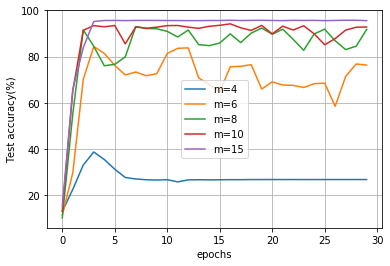

In [256]:
sel_m=10
sel_trial=0

plot_acc = np.mean(acc_test_arr, axis=1)
print(acc_test_arr.shape)
print(plot_acc.shape)

plt.plot(plot_acc[0,:],label='m=4')
plt.plot(plot_acc[2,:],label='m=6')
plt.plot(plot_acc[4,:],label='m=8')
plt.plot(plot_acc[6,:],label='m=10')
plt.plot(plot_acc[11,:],label='m=15')
plt.legend()
plt.grid()
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()


In [227]:
print(np.sort(idxs_users))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
